# 과대적합과 과소적합

[텍스트 분류](https://github.com/ksch28/AI/blob/main/Tensorflow_Tutorial/basic_text_classification.ipynb) 및 [연료 효율성 예측](https://github.com/ksch28/AI/blob/main/Tensorflow_Tutorial/regression.ipynb)이라는 두 가지 이전의 예에서 검증 데이터에 대한 모델의 정확도가 여러 에포크동안 훈련 후에 정점에 도달한 다음 정체되거나 감소되기 시작한것을 보았다.

즉, 위의 모델들은 <span style='background-color:#ffdce0'>훈련 데이터에 과대적합 된다.</span><br/>
과대적합에 대처하는 방법을 배우는 것은 중요하다.<br/>
내가 원하는 것은 훈련 세트에서 높은 정확도를 달성하는 것은 종종 가능하지만 <span style='background-color:#fff5b1'>테스트 세트(이전에 본 적 없는 데이터)에서 잘 일반화되는 모델을 개발하는 것이다.</span>

과대적합의 반대는 과소적합(underfitting)이다.<br/>
과소적합은 테스트 세트의 성능이 향상될 여지가 아직 있을 때 일어난다.<br/>
과소적합이 발생하는 원인은 여러가지인데, <span style='background-color:#ffdce0'>주로 모델이 너무 단순하거나 규제가 너무 많거나 그냥 단순히 오래 훈련하지 않았을 때 발생한다.</span><br/>
<span style='background-color:#ffdce0'>즉, 네트워크가 훈련 세트에서 적절한 패턴을 학습하지 못했다는 뜻이다.</span>

훈련을 너무 오래하면 모델이 과대적합을 하기 시작하며 테스트 데이터에 일반화되지 않는 훈련 데이터로부터 패턴을 학습한다.<br/>
이러한 경우 균형을 잘 잡아야 한다.<br/>
아래에서 탐색 할 <span style='background-color:#D0E4FC'>적절한 epoch수로 훈련하는 방법을 이해하는 것은 유용한 기술이다.</span>

과적합을 방지하기 위한 최상의 솔루션은 <span style='background-color:#fff5b1'>더 완전한 훈련 데이터를 사용하는 것이다.</span><br/>
데이터세트는 모델이 처리할 것으로 예상되는 전체 입력 범위를 포괄해야 한다. 추가 데이터는 새롭고 흥미로운 데이터를 다루는 경우에만 유용하게 사용할 수 있다.

더 완전한 훈련 데이터로 훈련된 모델은 자연스럽게 더 잘 일반화된다.<br/>
이것이 더이상 불가능할 경우, 차선책은 정규화와 같은 기술을 사용하는 것이다.<br/>
이는 모델이 저장할 수 있는 정보의 양과 유형에 제약을 가한다.<br/>
네트워크가 적은 수의 패턴만 기억할 수 있다면 최적화 프로세스는 일반화 가능성이 더 높은 가장 두드러진 패턴에 중점을 두도록 한다.<br/>

이 예제에서는 몇가지 일반적인 정규화 기술을 살펴보고 이를 분류 모델 개선에 적용한다.

# 0. 설정

시작하기 전에 필요한 패키지를 가져오자.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.3.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# 1. 힉스(Higgs) 데이터 세트

이 튜토리얼의 목표는 입자 물리학을 수행하는것이 아니므로 데이터 세트의 세부사항에 집중할 필요는 없다.<br/>
여기는 각각 28개의 특성과 이진 클래스 레이블이 있는 11,000,000개의 예제가 포함되어 있다.

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [7]:
FEATURES = 28

[tf.data.experimental.CsvDataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/CsvDataset?hl=ko) 클래스는 중간 압축 해제 단계 없이 gzip 파일에서 직접 csv 레코드를 읽는 데 사용할 수 있다.

In [8]:
ds = tf.data.experimental.CsvDataset(gz, [float(), ]*(FEATURES+1), compression_type='GZIP')

해당 csv 판독기 클래스는 각 레코드에 대한 스칼라 목록을 반환한다.<br/>
다음 함수는 해당 스칼라 목록을 (feature_vector, label)쌍으로 다시 압축한다.

In [9]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

Tensorflow는 대규모 데이터 배치에서 작업 할 때 가장 효율적이다.<br/>
따라서 각 행을 개별적으로 다시 압축하는 대신 10,000개 예제의 배치를 취하고 각 배치에 ```pack_row```함수를 적용한 다음 배치를 다시 개별 레코드로 분할하는 새로운 [```tf.data.Dataset```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko)을 만든다.

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

이 새로운 ```packed_ds```의 일부 레코드를 살펴보자.<br/>
특성이 완벽하게 정규화 되지는 않았지만, 이 튜토리얼에서는 이것으로도 충분하다

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


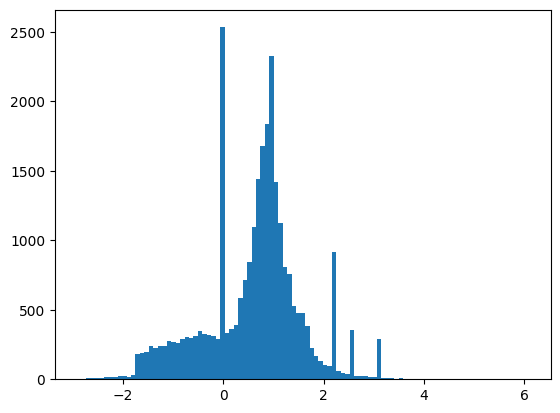

In [11]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

처음 1,000개의 샘플을 검증에 사용하고 다음 10,000개는 훈련에 사용한다.

In [12]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

[```Dataset.skip```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#skip) 및 [```Dataset.take```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#take) 메서드를 사용하면 이를 쉽게 수행할 수 있다.<br/>
동시에 [```Dataset.cache```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#cache) 메서드를 사용하여 로더가 각 epoch에서 파일의 데이터를 다시 읽을 필요가 없도록 해보자.

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

이러한 데이터세트는 개별 예제를 반환한다.<br/>
[```Dataset.batch```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#batch) 메서드를 사용하여 훈련에 적합한 크기의 배치를 생성한다.<br/>
또한 배치를 처리하기 전에 훈련 세트에 대해 [```Dataset.shuffle```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#shuffle) 및 [```Dataset.repeat```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#repeat)를 사용하는 것도 잊지 말자.

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# 2. 과대적합 예제

<span style='background-color:#fff5b1'>과적합을 방지하는 가장 간단한 방법은 작은 모델, 즉 학습 가능한 매개변수 수가 적은 모델(레이어 수와 레이어당 단위 수에 의해 결정됨)로 시각화 하는 것이다.</span><br/>
종종 딥러닝에서 모델의 학습 가능한 매개변수 수를 <span style='background-color:#fff5b1'>모델의 '용량'</span>이라고 한다.

직관적으로 생각할 때 더 많은 매개변수를 가진 모델이 더 많은 '기억 용량'을 가지므로 훈련 샘플과 대상 간에 완벽한 사전과 같은 매핑, 일반화 능력이 없는 매핑을 쉽게 학습할 수 있지만, 이전에 보지 못했던 데이터에서 예측할 때는 이것이 쓸모가 없다.

항상 명심할 점! 딥러닝 모델은 훈련 데이터에 피팅이 잘 되는 경향이 있지만, <span style='background-color:#fff5b1'>실제 문제는 피팅이 아닌 일반화이다.</span>

반면에 네트워크가 기억 리소스에 제한되어 있으면 매핑을 쉽게 학습할 수 없다.<br/>
손실을 최소화하려면 예측력이 더 높은 압축된 표현을 학습해야 한다.<br/>
동시에 모델을 너무 작게 만들면 훈련 데이터에 피팅하기가 어렵다. <span style='background-color:#fff5b1'>"용량이 너무 많음"과 "용량이 충분하지 않음" 사이에 균형이 존재해야 한다.</span>

불행히도 모델의 올바른 크기나 아키텍쳐(레이어 수 또는 각 레이어의 올바른 크기 측면에서)를 결정하는 마법과 같은 공식은 없다.<br/>
일련의 다른 아키텍쳐를 사용하여 실험해보아야 한다.

적절한 모델 크기를 찾으려면 비교적 적은 수의 레이어와 매개변수로 시작한 다음 유효성 검사 손실에 대한 이득 감소가 나타날 때까지<br/>
레이어의 크기를 늘리거나 새 레이어를 추가하는 것이 가장 좋다.

조밀하게 연결된 레이어([```tf.keras.layers.Dense```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=ko))만 사용하는 간단한 기준모델로 시작한 다음 더 큰 모델을 만들고, 모델들을 서로 비교한다.

## 2-1 기준 모델 만들기

훈련하는 동안 학습률을 점진적으로 낮추면 많은 모델이 더 잘 훈련된다. 시간 경과에 따른 학습률을 줄이려면 [```tf.keras.optimizers.schedules```](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules?hl=ko)를 사용해보자.

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                             decay_steps=STEPS_PER_EPOCH*1000,
                                                             decay_rate=1,
                                                             staircase=False)
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

위의 코드는 1,000epoch에서 학습률을 기본 학습률의 1/2로, 2,000 epoch에서는 1/3으로 쌍곡선 방식으로 줄이도록 [```tf.keras.optimizers.schedules.InverseTimeDecay```](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay?hl=ko)를 설정한다

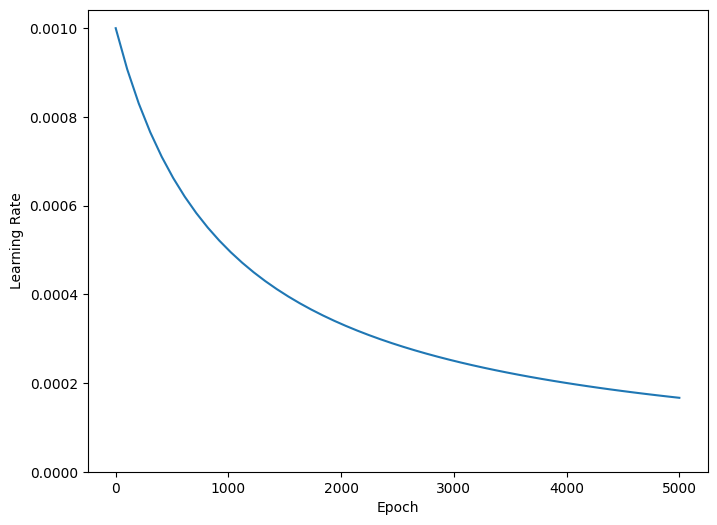

In [17]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

이 튜토리얼의 각 모델은 동일한 훈련 구성을 사용한다. 따라서 콜백 목록부터 시작하여 재사용 가능한 방식으로 설정하자.

이 튜토리얼의 훈련은 다수의 짧은 epoch동안 실행된다. 로깅 노이즈를 줄이기 위해 각 epoch에 대해 단순히 ```.```을 인쇄하고 100개의 epoch마다 전체 메트릭을 인쇄하는 ```tfdocs.EpochDots```를 사용한다.<br/>

다음으로, 길고 불필요한 훈련 시간을 줄이기 위해 [```tf.keras.callbacks.EarlyStopping```](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=ko)을 포함한다. 이 콜백은 ```val_loss```가 아니라 ```val_binary_crossentropy```를 모니터링하도록 설정되어 있다.

[```calbacks.TensorBoard```](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard?hl=ko)를 사용하여 훈련에 대한 TensorBoard 로그를 생성한다.

In [18]:
def get_callbacks(name):
    return[
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

마찬가지로 각 모델은 동일한 [```Model.compile```](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=ko#compile)및 [```Model.fit```](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=ko#fit)설정을 사용한다.

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'), 
                      'accuracy'])

    model.summary()
    
    history = model.fit(train_ds,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=validate_ds,
                        callbacks=get_callbacks(name),
                        verbose=0)
    
    return history

## 2-2 미소 모델

In [20]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(1)
])

In [21]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5253,  binary_crossentropy:0.8642,  loss:0.8642,  val_accuracy:0.4930,  val_binary_crossentropy:0.7532,  val_loss:0.7532,  
....................................................................................................
Epoch: 100, accuracy:0.5874,  binary_crossentropy:0.6297,  loss:0.6297,  val_accuracy:0.5840,  val_binary_crossentropy:0.6305,  val_loss:0.6305,  
....................................................................................................
Epoch: 200, accuracy:0.60

.......................

(0.5, 0.7)

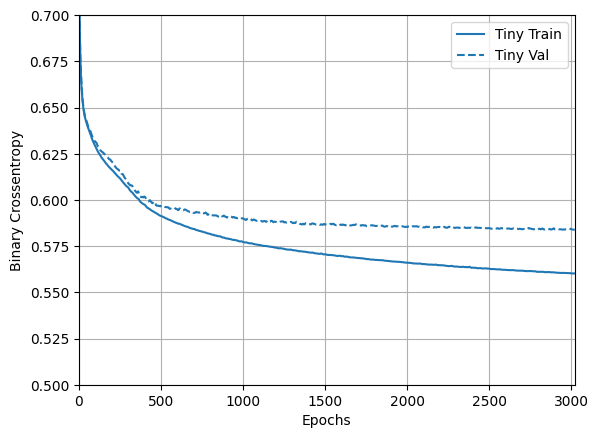

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## 2-3 작은 모델

작은 모델의 성능을 능가할 수 있는지 확인하기 위해 일부 큰 모델을 점진적으로 훈련한다.<br/>
각각 16개 단위가 있는 두 개의 은닉층을 사용해보자.

In [24]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4791,  binary_crossentropy:0.7428,  loss:0.7428,  val_accuracy:0.4550,  val_binary_crossentropy:0.7237,  val_loss:0.7237,  
....................................................................................................
Epoch: 100, accuracy:0.6384,  binary_crossentropy:0.6036,  loss:0.6036,  val_accuracy:0.6350,  val_binary_crossentropy:0.6008,  val_loss:0.

## 2-4 작은 모델 만들기

이제 각각 64개의 단위가 있는 3개의 은닉층을 만들어보자.

In [26]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [27]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4929,  binary_crossentropy:0.6878,  loss:0.6878,  val_accuracy:0.4670,  val_binary_crossentropy:0.6757,  val_loss:0.6757,  
....................................................................................................
E

## 2-5 큰 모델 만들기

연습으로 더 큰 모델을 만들고 얼마나 빨리 과대적합을 시작하는지 확인할 수 있다.<br/>
다음으로, 문제가 보증하는 것보다 훨씬 더 많은 용량의 네트워크를 이 벤치마크에 추가한다.

In [28]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

역시 같은 데이터를 사용해 모델을 훈련한다.

In [29]:
size_histories['large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5057,  binary_crossentropy:0.7823,  loss:0.7823,  val_accuracy:0.5270,  val_binary_crossentr

## 2-6 훈련 손실과 검증 손실 그래프 그리기

실선은 훈련 손실을 나타내고 점선은 유효성 검사 손실을 나타낸다.<br/>
유효성 검사 손실이 낮을수록 더 나은 모델을 나타낸다.

더 큰 모델을 빌드하면 더 많은 파워가 제공되지만 이 파워가 어떤 이유로 제한되지 않으면 훈련세트에 쉽게 과대적합될 수 있다.

이 예에서는 일반적으로 ```"Tiny"``` 모델만 과대적합을 완전히 피하고 더 큰 각 모델은 데이터를 더 빠르게 과대적합한다.<br/>
```"large"``` 모델의 경우 이것이 너무 심각해져서 실제로 어떤 상황이 발생하는지 파악하려면 플롯을 로그 스케일로 전환해야 한다.

검증 메트릭을 플롯하고 이를 훈련 메트릭과 비교하면 이것이 분명해진다.

* 약간의 차이가 있는 것이 정상이다.
* 두 메트릭이 같은 방향으로 움직이면 모든 것이 정상이다.
* 훈련 메트릭이 계속 개선되는 동안 검증 메트릭이 정체되기 시작하면 과대적합에 가까워진 것이다.
* 검증 메트릭이 잘못된 방향으로 가고 있다면 모델이 확실하게 과대적합된 것이다.

Text(0.5, 0, 'Epochs [Log Scale]')

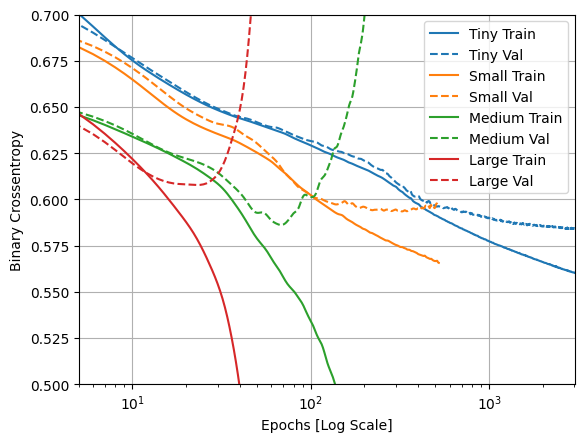

In [30]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Epochs [Log Scale]')

## 2-7 TensorBoard에서 보기

In [31]:
%load_ext tensorboard

In [32]:
%tensorboard --logdir {logdir}/sizes

# 3. 과대적합을 방지하기 위한 전략

이 섹션의 내용을 시작하기 전에 위의 ```"Tiny"``` 모델에서 훈련 로그를 복사하여 비교 기준으로 사용한다.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpyccvw46c/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## 3-1 가중치 규제하기

오캄의 면도날(Occam's Razor) 이론을 예로 들어보자.<br/>
오캄의 면도날 이론이란, <span style='background-color:#fff5b1'>어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 '간단한'설명이다 라는 내용이다.</span>

이는 신경망으로 학습되는 모델에도 적용이 된다.<br/>
훈련 데이터와 네트워크 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치의 조합(즉, 가능한 모델)은 많다. 간단한 모델은 복잡한 것보다 과대적합되는 경향이 작을 것이다.

여기에서 말하는 <span style='background-color:#fff5b1'>"간단한 모델"은 매개변수 값의 분포가 엔트로피가 적은 모델(또는 위의 섹션에서 설명한 것처럼 매개변수가 거의 없는 모델)이다.</span><br/>
따라서 과대적합을 완화하는 일반적인 방법은 <span style='background-color:#fff5b1'>가중치가 작은 값만 사용하도록 하여 가중치 값의 분포를 보다 "정규화"하여 네트워크의 복잡성에 제약을 가하는 것이다.</span>

이것을 <span style='background-color:#D0E4FC'>"가중치 정규화"</span>라고 하며, <span style='background-color:#D0E4FC'>큰 가중치를 갖는 것과 관련된 비용을 네트워크의 손실 함수에 추가하는 방식으로 수행된다.</span><br/>
이 비용은 다음과 같이 두 가지 형태로 제공된다.

* [L1 규제](https://developers.google.com/machine-learning/glossary/?hl=ko#L1_regularization)는 <span style='background-color:#D0E4FC'>가중치의 절댓값에 비례하는 비용이 추가된다.(즉, 가중치의 "L1 노름(norm)"을 추가한다)</span>
* [L2 규제](https://developers.google.com/machine-learning/glossary/?hl=ko#L2_regularization)는 <span style='background-color:#D0E4FC'>가중치의 제곱에 비례하는 비용이 추가된다.(즉, 가중치의 "L2 노름"의 제곱을 추가한다.)</span><br/>신경망에서는 L2 규제를 가중치 감쇠(weight decay)라고도 부른다. 이 둘은 이름이 다르지만 수학적으로 동일하다.

L1 정규화는 가중치를 정확히 0으로 푸시하여 희소 모델을 유도한다.<br/>
L2 정규화는 가중치 매개변수를 희소하게 만들지 않고 여기에 패널티를 부여하는데, 이는 작은 가중치에 대해서는 패널티가 0이 되기 때문이다.(L2가 일반적인 이유)

[```tf.keras```](https://www.tensorflow.org/api_docs/python/tf/keras?hl=ko)에서는 가중치 정규화 인스턴스를 레이어에 키워드로 전달함으로써 가중치 정규화가 추가된다.

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES, )),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5137,  binary_crossentropy:0.8051,  loss:2.3274,  val_accuracy:0.4840,  val_binary_crossentr

```l2(0.001)```은 네트워크의 전체 손실 층에 있는 가중치 행렬의 모든 값이 ```0.001 * weight_coefficient_value**2``` 만큼 더해진다는 의미이다.<br/>
이런 패널티는 훈련 할때만 추가된다. 따라서 테스트 단계보다 훈련 단게에서 네트워크 손실이 더 클 것이다.

이것이 바로 이 정규화 구성 요소가 혼합되어 있지 않기 때문에 우리가 ```binary_crossentropy```를 직접 모니터링 하는 이유이다.

따라서 ```L2``` 정규화 패널티가 있는 이 동일한 ```'Large'``` 모델의 성능이 훨씬 더 좋다.

(0.5, 0.7)

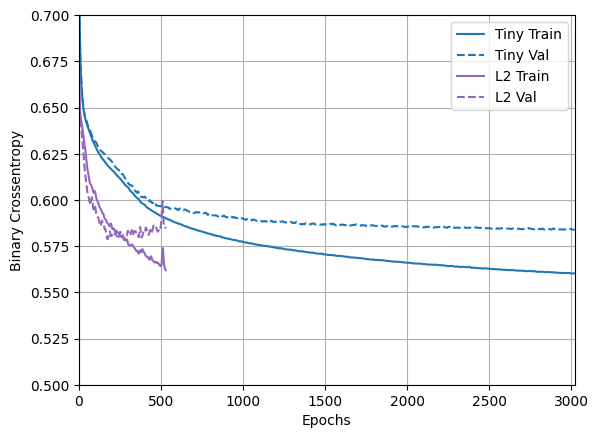

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

위의 다이어그램과 같이 ```"L2"``` 정규화 모델은 ```"Tiny"``` 모델에 비해 훨씬 더 경쟁력이 있다.<br/>
이 ```"L2"```모델은 ```"Large"``` 모델과 동일한 수의 매개변수를 가지고 있음에도 과대적합에 훨씬 더 강하다.

### 더 많은 정보

다음과 같이 이러한 종류의 정규화에 대해 주목해야 할 두 가지 중요한 사항이 있다.

1. 자체 훈련 루프를 작성하는 경우 모델에 정규화 손실을 요청해야 한다.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. 이 구현은 모델의 손실에 가중치 패널티를 추가한 다음 표준 최적화 절차를 적용하는 식으로 작동한다.

대신에 원시 손실에 대해서만 옵티마이저를 실행한 다음 계산된 단계를 적용하는 동안 옵티마이저가 약간의 가중치 감소를 적용하는 두 번째 접근 방식이 있다.<br/>
이 "분리된 가중치 감소"는 [```tf.keras.optimizers.Ftrl```](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/Ftrl?hl=ko)및 [```tfa.optimizers.AdamW```](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW?hl=ko)와 같은 옵티마이저에서 사용된다.

## 3-2 드롭아웃 추가하기

드롭아웃은 신경망에 대해 가장 효과적이고 가장 일반적으로 사용되는 정규화 기술 중 하나로, 토론토 대학에서 Hinton과 그의 학생들이 개발했다.

<span style='background-color:#D0E4FC'>드롭아웃</span>을 직관적으로 설명하면, <span style='background-color:#D0E4FC'>네트워크의 개별 노드가 다른 노드의 출력에 의존할 수 없기 때문에 각 노드는 자체적으로 유용한 요소를 출력해야 한다는 것이다.</span>

레이어에 적용되는 드롭아웃은 훈련 중에 레이어의 여러 출력 요소를 무작위로 "드롭아웃"(즉, 0으로 설정)하는 식으로 작동한다.<br/>
예를 들어 보통의 경우 주어진 레이어는 훈련 중 주어진 입력 샘플에 대해 벡터 ```[0.2, 0.5, 1.3, 0.8, 1.1]```을 반환할 수 있다.<br/>
드롭아웃을 적용한 후 이 벡터에는 무작위로 분포된 몇 개의 0 항목이 있다.(```[0, 0.5, 1.3, 0, 1.1]```)

"드롭아웃 비율"은 0이 되는 특성의 비율로, 일반적으로 0.2 ~ 0.5 사이로 설정된다.<br/>
테스트 시간에는 어떤 유닛도 드롭아웃되지 않고 대신 레이어의 출력 값이 드롭아웃 비율과 동일한 계수만큼 축소되는데,<br/>
이는 훈련 시간에 더 많은 유닛이 활성화된다는 사실과 균형을 맞추기 위해서이다.

Keras에서는 [```tf.keras.layers.Dropout```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout?hl=ko) 레이어를 통해 네트워크에 드롭아웃을 도입할 수 있다.<br/>
이 레이어는 직전 레이어의 출력에 적용된다.

레이어의 두 개의 드롭아웃 레이어를 추가하여 과대적합을 줄이는 효과가 얼마나 되는지 확인해보자.

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES, )),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

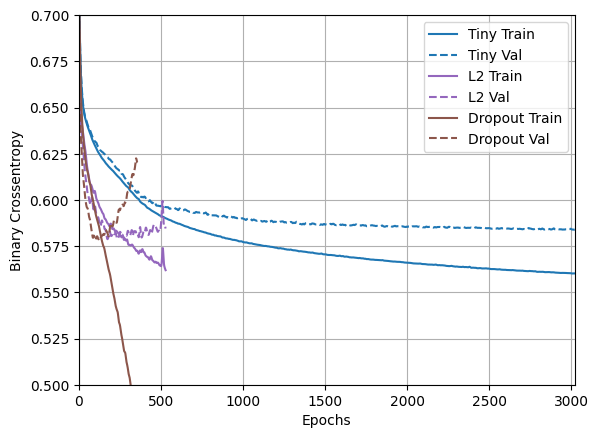

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

이 플롯으로부터 이러한 정규화 접근 방식 모두 ```"Large"``` 모델의 동작을 개선한다는 것이 분명하다.<br/>
그러나 여전히 ```"Tiny"``` 기준을 넘어서지는 못하고 있다.

다음으로, L2규제와 드롭아웃을 함께 실행하고 더 나은지 확인해보자.

## 3-3 L2 + 드롭아웃 결합

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

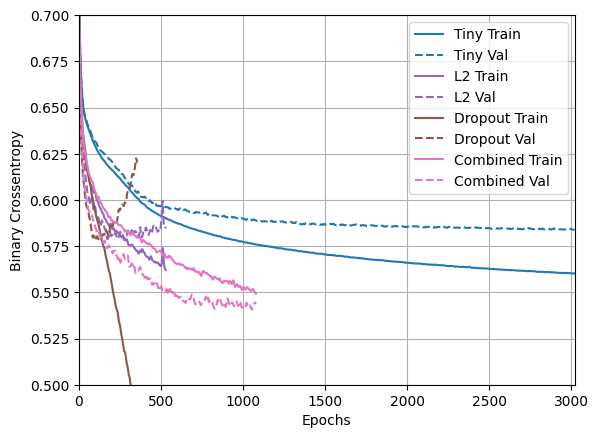

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

```"combined"``` 정규화가 있는 이 모델은 분명히 지금까지 최고의 모델이다.

## 3-4 TensorBoard에서 보기

이러한 모델들은 TensorBoard 로그도 기록했다.

In [42]:
%tensorboard --logdir {logdir}/regularizers

# 4. 결론

요약하자면 신경망에서 과대적합을 방지하는 가장 일반적인 전략은 다음과 같다.

1. 더 많은 훈련 데이터를 얻는다.
2. 네트워크 용량을 줄인다.
3. 가중치 정규화를 추가한다.
4. 드롭아웃을 추가한다.

이 가이드에서 다루지 않은 두 가지 중요한 접근은 다음과 같다.

1. 데이터 증강
2. 배치 정규화([```tf.keras.layers.BatchNormalization```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?hl=ko))

각각의 방법은 그 자체로 도움이 될 수 있지만, 이를 결합하여 더 큰 효과를 거둘 수 있는 경우가 종종 있다는 점을 기억하자.